## Task:  
Time-series analysis - predict monthly sales one quarter ahead.  
Model - ridge regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge

pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
# Read metadata file
meta = pd.read_csv("metadata.csv")

# Filter metadata according to our needs
meta = meta[
        (meta.report == "Manufacturing and Trade Inventories and Sales") & \
        (meta.cat_desc == "Manufacturers") & \
        (meta.is_adj == 0)
]

meta

,cat_code,cat_desc,category_level,dt_code,dt_desc,dt_unit,et_code,et_desc,et_unit,geo_code,geo_desc,is_adj,report,detail_code,time_series_code
2420,MNFCTR,Manufacturers,0,SM,Sales - Monthly,Millions of Dollars,NaN,NaN,NaN,US,U.S. Total,0,Manufacturing and Trade Inventories and Sales,SM,MNFCTR_SM_US
2428,MNFCTR,Manufacturers,0,IM,Inventories - Monthly,Millions of Dollars,NaN,NaN,NaN,US,U.S. Total,0,Manufacturing and Trade Inventories and Sales,IM,MNFCTR_IM_US
2436,MNFCTR,Manufacturers,0,IR,Inventories/Sales Ratio,Ratio,NaN,NaN,NaN,US,U.S. Total,0,Manufacturing and Trade Inventories and Sales,IR,MNFCTR_IR_US
2444,MNFCTR,Manufacturers,0,MPCIM,Inventories - Monthly Percent Change,Percent,NaN,NaN,NaN,US,U.S. Total,0,Manufacturing and Trade Inventories and Sales,MPCIM,MNFCTR_MPCIM_US
2452,MNFCTR,Manufacturers,0,MPCSM,Sales - Monthly Percent Change,Percent,NaN,NaN,NaN,US,U.S. Total,0,Manufacturing and Trade Inventories and Sales,MPCSM,MNFCTR_MPCSM_US


In [3]:
# Read time-series data
data = pd.read_csv("data.csv", parse_dates=["date"], low_memory=False)

# Merge with required metadata
data = pd.merge(left=data,
                right=meta[["dt_desc", "dt_unit", "time_series_code"]],
                how="inner",
                on="time_series_code"
               )

data.sort_values(by=["time_series_code", "date"], inplace=True)
data["value"] = data["value"].astype(float) # since dtype was mixed initially

print(data.shape)
data.head(3)

(1538, 5)


,time_series_code,date,value,dt_desc,dt_unit
308,MNFCTR_IM_US,1992-01-01,375389.0,Inventories - Monthly,Millions of Dollars
309,MNFCTR_IM_US,1992-02-01,378146.0,Inventories - Monthly,Millions of Dollars
310,MNFCTR_IM_US,1992-03-01,377223.0,Inventories - Monthly,Millions of Dollars


In [4]:
# High-level overview of data
data.groupby(["time_series_code", "dt_desc", "dt_unit"])[["date", "value"]] \
    .agg(["count", "min", "max"])

date  \
                                                                            count   
time_series_code dt_desc                              dt_unit                       
MNFCTR_IM_US     Inventories - Monthly                  Millions of Dollars   308   
MNFCTR_IR_US     Inventories/Sales Ratio              Ratio                   308   
MNFCTR_MPCIM_US  Inventories - Monthly Percent Change   Percent               307   
MNFCTR_MPCSM_US  Sales - Monthly Percent Change         Percent               307   
MNFCTR_SM_US     Sales - Monthly                        Millions of Dollars   308   

                                                                                        \
                                                                                   min   
time_series_code dt_desc                              dt_unit                            
MNFCTR_IM_US     Inventories - Monthly                  Millions of Dollars 1992-01-01   
MNFCTR_IR_US     Inventories/Sales Ratio              Ratio                 1992-01-01   
MNFCTR_MPCIM_US  Inventories - Monthly Percent Change   Percent             1992-02-01   
MNFCTR_MPCSM_US  Sales - Monthly Percent Change         Percent             1992-02-01   
MNFCTR_SM_US     Sales - Monthly                        Millions of Dollars 1992-01-01   

                                                                                        \
                                                                                   max   
time_series_code dt_desc                              dt_unit                            
MNFCTR_IM_US     Inventories - Monthly                  Millions of Dollars 2017-08-01   
MNFCTR_IR_US     Inventories/Sales Ratio              Ratio                 2017-08-01   
MNFCTR_MPCIM_US  Inventories - Monthly Percent Change   Percent             2017-08-01   
MNFCTR_MPCSM_US  Sales - Monthly Percent Change         Percent             2017-08-01   
MNFCTR_SM_US     Sales - Monthly                        Millions of Dollars 2017-08-01   

                                                                            value  \
                                                                            count   
time_series_code dt_desc                              dt_unit                       
MNFCTR_IM_US     Inventories - Monthly                  Millions of Dollars   308   
MNFCTR_IR_US     Inventories/Sales Ratio              Ratio                   308   
MNFCTR_MPCIM_US  Inventories - Monthly Percent Change   Percent               307   
MNFCTR_MPCSM_US  Sales - Monthly Percent Change         Percent               307   
MNFCTR_SM_US     Sales - Monthly                        Millions of Dollars   308   

                                                                                        \
                                                                                   min   
time_series_code dt_desc                              dt_unit                            
MNFCTR_IM_US     Inventories - Monthly                  Millions of Dollars  369673.00   
MNFCTR_IR_US     Inventories/Sales Ratio              Ratio                       1.09   
MNFCTR_MPCIM_US  Inventories - Monthly Percent Change   Percent                  -5.60   
MNFCTR_MPCSM_US  Sales - Monthly Percent Change         Percent                 -17.80   
MNFCTR_SM_US     Sales - Monthly                        Millions of Dollars  209438.00   

                                                                                        
                                                                                   max  
time_series_code dt_desc                              dt_unit                           
MNFCTR_IM_US     Inventories - Monthly                  Millions of Dollars  660552.00  
MNFCTR_IR_US     Inventories/Sales Ratio              Ratio                       1.79  
MNFCTR_MPCIM_US  Inventories - Monthly Percent Change   Percent                   3.80  
MNFCTR_MPCSM_US  S

In [5]:
cols_alias = {
    "Inventories - Monthly": "Inventories, $M",
    "Inventories - Monthly Percent Change": "Inventories, %change",
    "Sales - Monthly": "Sales, $M",
    "Sales - Monthly Percent Change": "Sales, %change",                
}

# Convert long-format dataframe to pivot table on monthly basis
mth = data.pivot(index="date", columns="dt_desc", values="value") \
          .rename(columns=cols_alias)

mth.head(3)

dt_desc,"Inventories, $M","Inventories, %change",Inventories/Sales Ratio,"Sales, $M","Sales, %change"
date,,,,,
1992-01-01,375389.0,NaN,1.79,209438.0,NaN
1992-02-01,378146.0,0.7,1.63,232679.0,11.1
1992-03-01,377223.0,-0.2,1.51,249673.0,7.3


In [6]:
# Aggregate data also on quarterly basis
qrt = mth.resample("QS").agg("sum").iloc[:-1]

# Ratios and %% columns should be recalculated
qrt["Inventories/Sales Ratio"] = \
    qrt["Inventories, $M"] / qrt["Sales, $M"]

qrt["Inventories, %change"] = \
    100*(qrt["Inventories, $M"] / qrt["Inventories, $M"].shift()) - 100

qrt["Sales, %change"] = \
    100*(qrt["Sales, $M"] / qrt["Sales, $M"].shift()) - 100

qrt.head(3)

dt_desc,"Inventories, $M","Inventories, %change",Inventories/Sales Ratio,"Sales, $M","Sales, %change"
date,,,,,
1992-01-01,1130758.0,NaN,1.634539,691790.0,NaN
1992-04-01,1135505.0,0.419807,1.522633,745751.0,7.800199
1992-07-01,1141562.0,0.533419,1.578166,723347.0,-3.004220


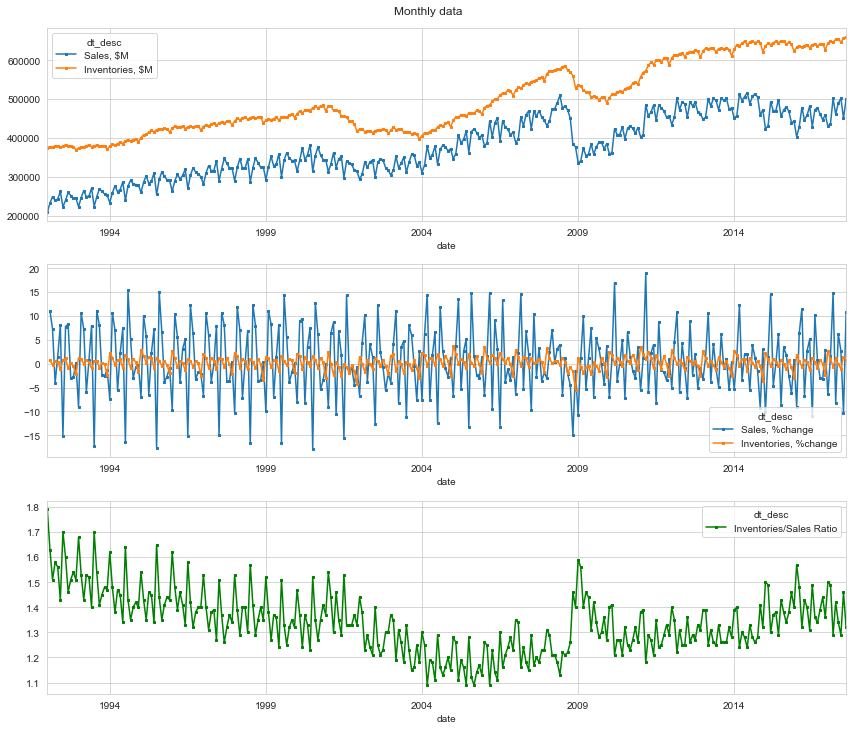

In [7]:
# Plot monthly data
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,10))
mth[["Sales, $M", "Inventories, $M"]] \
    .plot(marker="s", markersize=2, ax=ax[0]);

mth[["Sales, %change", "Inventories, %change"]] \
    .plot(marker="s", markersize=2, ax=ax[1]);

mth[["Inventories/Sales Ratio"]] \
    .plot(marker="s", markersize=2, ax=ax[2], color="g");

fig.suptitle("Monthly data", y=1.01);
fig.tight_layout()

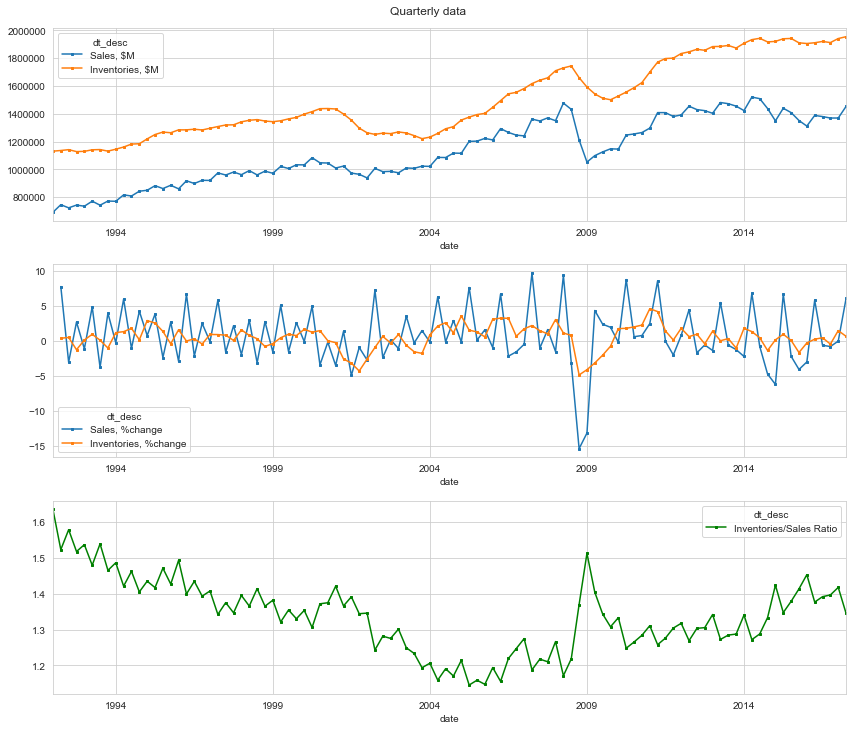

In [8]:
# Plot quarterly data
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,10))

qrt[["Sales, $M", "Inventories, $M"]] \
    .plot(marker="s", markersize=2, ax=ax[0]);

qrt[["Sales, %change", "Inventories, %change"]] \
    .plot(marker="s", markersize=2, ax=ax[1]);

qrt[["Inventories/Sales Ratio"]] \
    .plot(marker="s", markersize=2, ax=ax[2], color="g");

fig.suptitle("Quarterly data", y=1.01);
fig.tight_layout()

Several take-aways:
- There are 2 crises reflected in sales data (beginning of 2000s - weak, end of 2008 - strong)
- Inventories and sales have similar patterns, however inventories slightly lags
- Inventories have lower elasticity to demand change (vs. sales)
- Sales seem to have yearly seasonality-
- Inventory / Sales ratio is somewhat lower in 2000s - 2010s vs. 1990s, probably because of improved working capital management

Now we will train predictive model to forecast sales on monthly basis one quarter ahead.

`Note:` nobody can predict future crises, so it leads to intuition, that there is no point to train model on such time periods. Following this idea, time-period of the last financial crisis (2008) will not be used further.

In [9]:
targ_name = "Sales, $M"
feat_names = ["Sales, $M", "Inventories, $M", "Inventories/Sales Ratio"]
n_lag = 12 # window size for lagged data
horizon = 3 # forecast one quarter ahead

# Generate lagged factors
lags = []
for i in range(n_lag):
    df_lag = mth[feat_names].shift(i)
    df_lag.columns = [col + f" (t-{i})" for col in df_lag.columns]
    lags.append(df_lag)

X = pd.concat(lags, axis=1).dropna()

# Adding dummy variable of current month
X["month"] = X.index.month
X = pd.get_dummies(X, columns=["month"], drop_first=True)

# Test data, last available data point
X_test = X.iloc[[-1]]

# Exclude crisis months Oct.2008-Jan.2009
X = X[(X.index <= pd.to_datetime("2008-10-01") - pd.DateOffset(months=horizon)) | \
      (X.index >= pd.to_datetime("2008-10-01"))]

# Set target variables (multi-output)
Y = pd.concat([mth[targ_name].shift(-i-1) for i in range(horizon)], axis=1)
Y.columns = [targ_name + f" (t+{i+1})" for i in range(horizon)]
Y = Y.reindex(X.index)

# Drop last observations since they contain NaN values (not enough data)
X = X.iloc[:-horizon]
Y = Y.iloc[:-horizon]

We will use rolling window approach for model backtesting:  
`Reference:` https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html

In [10]:
def get_rolling_splits(n, min_window):
    """
    Generates train/test indices to split time-series data 
    using expanding rolling window approach.
    """
    idxs = np.arange(n)
    for i in range(min_window, n):
        train_idxs = idxs[:i]
        test_idxs = idxs[i:i+1] # just one sample
        yield train_idxs, test_idxs
        

def error_at_index(y, y_pred, index):
    """Returns error of one sample at specific time-step (index)"""
    return y_pred.ravel()[index] - y.values.ravel()[index]

In [11]:
# Minimum 3 years of monthly data to fit the model
min_window = 3*12 

# Generate CV train/test indices
cv_idxs = [(train, test) for train, test in \
               get_rolling_splits(n=len(X), min_window=min_window)]

# Evaluate absolute error at each time step of forecasting horizon
scorers = {f"err@{k+1}": make_scorer(error_at_index, index=k) \
               for k in range(horizon)}

# Initialize model
model = Ridge(normalize=False, alpha=.01, random_state=13)

# Cross validate time-series data
cv_res = cross_validate(model, X, Y,
                        scoring=scorers,
                        cv=cv_idxs,
                        return_train_score=False,
                       )

# Aggregate CV errors
cv_err = {**{f"mae_@{k+1}": np.mean(np.abs(cv_res[f"test_err@{k+1}"])) \
                 for k in range(horizon)},
          **{f"bias_@{k+1}": np.mean(cv_res[f"test_err@{k+1}"]) \
                 for k in range(horizon)}
         }

cv_err

{'mae_@1': 7549.885529196484,
 'mae_@2': 8779.002314575453,
 'mae_@3': 10036.473659186358,
 'bias_@1': -173.13837889833985,
 'bias_@2': -168.90223955904776,
 'bias_@3': -229.3113928363863}

Comments:
- MAE is increasing for further months, which makes sense
- Bias is insignificant, i.e. there is no over-/underprediction

Now we can plot the results of backtesting using rolling window CV strategy.

In [12]:
def partitial_cross_val_predict(model, X, Y, cv):
    """Stores predictions and indices of CV test partitions"""
    idxs, preds = [], []
    for train_idxs, test_idxs in cv_idxs:
        model.fit(X.iloc[train_idxs], Y.iloc[train_idxs]);
        pred = model.predict(X.iloc[test_idxs])
        preds.append(pred.ravel())
        idxs.append(test_idxs.item())
    return idxs, preds


cv_test, cv_pred = partitial_cross_val_predict(model, X, Y, cv=cv_idxs)

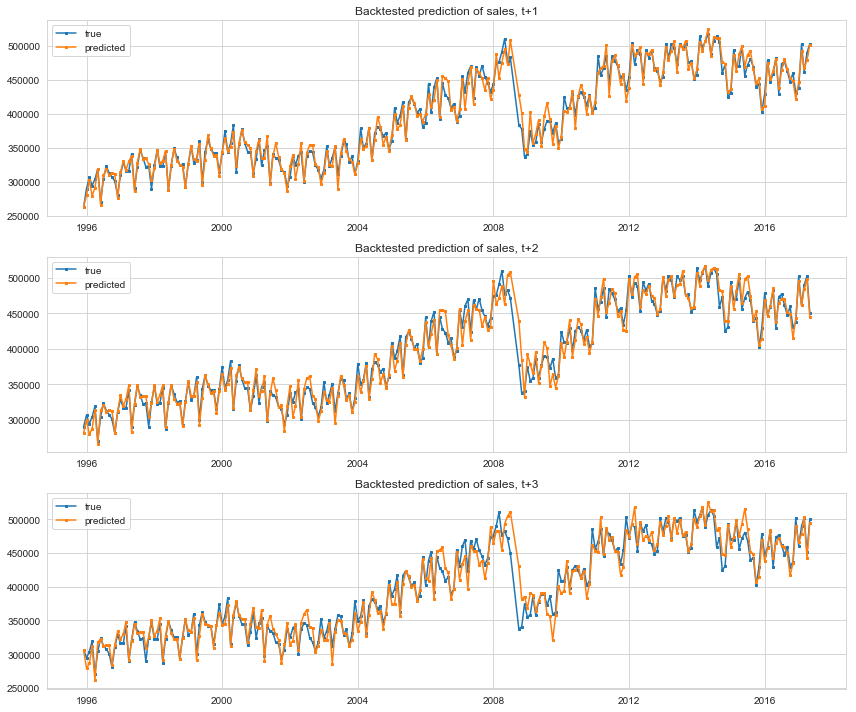

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,10))

# Plot factual/predicted CV samples for each time-step within horizon
for h in range(horizon):
    y_true = Y.iloc[cv_test, h]
    y_pred = pd.Series([x[h] for x in cv_pred], index=y_true.index)
    ax[h].plot(y_true, marker="s", markersize=2, label="true");
    ax[h].plot(y_pred, marker="s", markersize=2, label="predicted");
    ax[h].set_title(f"Backtested prediction of sales, t+{h+1}")
    ax[h].legend(loc="upper left")

fig.tight_layout();

One can see, the model performs well in general, it also captures seasonal nature of data.

We can make out-of-sample prediction of sales.  
To estimate prediction intervals, bootstrap procedure could be applied.

In [14]:
def predict_out_of_sample(model, X_train, Y_train, X_test):
    """Calculates prediction with bootstrapped prediction intervals"""
    months = pd.date_range(start=X_test.index[0], periods=horizon+1, closed="right", freq="MS")
    N = X_train.shape[0]
    idxs = np.arange(N)
    n_round = 1000
    preds = []
    for i in range(n_round):
        idxs_boot = np.random.choice(idxs, size=N, replace=True)
        model.fit(X_train.iloc[idxs_boot], Y_train.iloc[idxs_boot]);
        y_pred = model.predict(X_test)
        preds.append(y_pred.ravel())        
    preds = pd.DataFrame.from_records(preds, columns=months)
    stats = preds.describe(percentiles=[.05, .5, .95]).loc[["5%", "50%", "95%"]].T
    return stats

Y_pred = predict_out_of_sample(model, X, Y, X_test)
Y_pred

,5%,50%,95%
2017-09-01,494200.880738,499416.945668,505068.546581
2017-10-01,485284.325280,491838.658776,498326.208021
2017-11-01,468334.093069,476031.947017,483567.766957


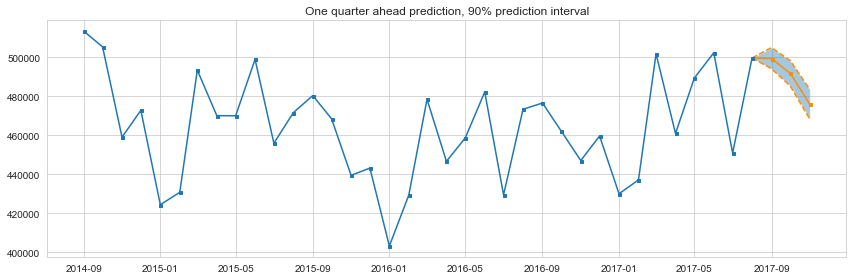

In [15]:
# Plot factual (last N points) and predicted data
fig, ax = plt.subplots(figsize=(12,4));

fact_plot = mth["Sales, $M"].iloc[-36:]
Y_pred.loc[fact_plot.index[-1]] = fact_plot.values[-1]
Y_pred.sort_index(inplace=True)

ax.plot(Y_pred["50%"], marker="s", markersize=3, color="darkorange");
ax.plot(Y_pred["5%"], color="darkorange", linestyle="--");
ax.plot(Y_pred["95%"], color="darkorange", linestyle="--");
ax.plot(fact_plot, marker="s", markersize=3);
ax.fill_between(x=Y_pred.index, y1=Y_pred["5%"], y2=Y_pred["95%"], alpha=.4);
ax.set_title("One quarter ahead prediction, 90% prediction interval")
plt.tight_layout();